In [1]:

# SETUP --------------------------
from analysis.toolbox import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, GPT2LMHeadModel, PhrasalConstraint, QuantoConfig
from undecorated import undecorated
from types import MethodType
import copy
import time
import pickle
import io
import os
from tqdm import tqdm

import mlflow

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.set_default_device(device)
print(f"Using {device} device")
print(torch.tensor([1, 2, 3]).device)

# MAGICKS --------------------------
s_model = "gpt2"
iSeed = 4523522
sPadding = "left"
sNameAEModel = "Hair20eos"



lTargetStrings = [
    # Health Benefits
    "Boost Your Immunity with Every Spoonful.",
    "Packed with Probiotics for a Healthier You.",
    "Nourish Your Body with Natural Goodness.",
    "Strengthen Your Gut with Live Cultures.",
    "Low in Sugar, High in Vital Nutrients.",
    "Daily Dose of Calcium for Strong Bones.",
    "Feel Energized with Protein-Rich Yoghurt.",
    "Healthy Digestion Starts Here.",
    "Antioxidant-Rich for a Balanced Diet.",
    "Supports Heart Health with Omega-3s.",
    
    # Taste
    "Indulge in Creamy Delight.",
    "Rich, Velvety Texture in Every Bite.",
    "Taste the Burst of Real Fruit Flavor.",
    "Pure Decadence Without the Guilt.",
    "Experience the Silky Smooth Perfection.",
    "Savor the Freshness of Farm-Fresh Ingredients.",
    "Gourmet Flavors to Satisfy Your Cravings.",
    "Deliciously Tangy, Perfectly Sweet.",
    "Treat Your Taste Buds to Luxurious Bliss.",
    "Heavenly Taste in Every Spoonful."
]

lTargetStrings = [
    "Experience 50% more visible shine after just one use.", #0
    "Formulated with light-reflecting technology for a glossy finish.", #1
    "Transform dull strands into radiant, luminous locks.", #2
    "Infused with nourishing oils that enhance natural shine.", #3
    "See instant brilliance with our advanced shine-boosting formula.", #4
    "Locks in moisture to amplify hair's natural luster.", #5
    "Achieve salon-quality shine without leaving home.", #6
    "Visible reduction in dullness, replaced with stunning shine.", #7
    "Say goodbye to lackluster hair, hello to mirror-like shine.", #8
    "Clinically proven to enhance shine by up to 70%.", # ^tangible #9
    "Elevate your confidence with hair that gleams under any light.", #10
    "Embrace the allure of luminous hair that turns heads.", #11
    "Unleash the power of radiant hair that speaks volumes.", #12
    "Transform your look with hair that exudes brilliance.", #13
    "Feel the difference of hair that shines with vitality and health.", #14
    "Rediscover the joy of hair that beams with inner vibrancy.", #15
    "Indulge in the luxury of hair that shimmers with elegance.", #16
    "Step into the spotlight with hair that radiates beauty.", #17
    "Experience the magic of hair that dazzles with every movement.", #18
    "Unlock the secret to hair that shines from within, reflecting your inner glow." #19,
]

iClaims = len(lTargetStrings)
iEncodingDim = 2
iOutputSize = 768

torch.manual_seed(iSeed)
model = GPT2LMHeadModel.from_pretrained(s_model, device_map=device, resume_download=True)
tokenizer = AutoTokenizer.from_pretrained(s_model, resume_download=True)

if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

tOHETarget = create_input_data(iClaims)
tTargetStrings, lLengths = TokenizeClaims(lTargetStrings, tokenizer)
iMaxTokens = max(lLengths)

tInputEmbeddings = model.get_input_embeddings()(tTargetStrings)
# TODO: Put mask at the beginning or the end? Beginning seems more plausible, and yields to higher loss
# TODO: Look into `past_key_values`, can speed things up by caching the hidden states
tTarget = torch.cat([torch.tensor([-100] * iClaims).unsqueeze(-1), tTargetStrings], dim = 1)


class Autoencoder(nn.Module):
   def __init__(self, input_size, encoding_dim, output_size):
       super(Autoencoder, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, encoding_dim, bias=True)
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, output_size, bias=True)
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x
   
import torch
from torch.optim.optimizer import Optimizer, required

# Implement a constant step optimizer; Newton Raphson, lr is \delta x
class ConstantStepOptimizer(Optimizer):
    def __init__(self, params, lr=required):
        if lr is not required and lr <= 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr)
        super(ConstantStepOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    d_p = p.grad.data
                    p.data.add_(-lr * d_p)

        return loss
    
    
ae = Autoencoder(iClaims, iEncodingDim, iOutputSize)
iBatchSize = min(32, iClaims)

/Users/hoener/miniforge3/envs/mphil/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using mps device
mps:0


In [2]:
iE = 164
ae_old = torch.load(f"log_models copy/models_{iE - 10}/data/model.pth")
ae = torch.load(f"log_models copy/models_{iE}/data/model.pth")
ae_new = torch.load(f"log_models copy/models_{iE + 1}/data/model.pth")
ae_new_new = torch.load(f"log_models copy/models_{iE + 10}/data/model.pth")

# init almost all parts with new weights
tStepEncoderWeight = ae_new.encoder[0].weight.data - ae.encoder[0].weight.data
tStepDecoderWeight = ae_new.decoder[0].weight.data - ae.decoder[0].weight.data
tStepEncoderBias = ae_new.encoder[0].bias.data - ae.encoder[0].bias.data
tStepDecoderBias = ae_new.decoder[0].bias.data - ae.decoder[0].bias.data

#ae.encoder[0].weight.data = ae_new.encoder[0].weight.data
#ae.decoder[0].weight.data = ae_new.decoder[0].weight.data
# ae.encoder[0].bias.data = ae_new.encoder[0].bias.data
#ae.decoder[0].bias.data = ae_new.decoder[0].bias.data

# now move over the encoder weights, this should be a slice that incorporates the "interactions" between
# the steps?

In [6]:
# generate iMaxTokens + 1 to account for EOS of longest claim
lGenOld = model.generate(inputs_embeds = ae_old(tOHETarget).unsqueeze(1), max_new_tokens = 20, pad_token_id = tokenizer.pad_token_id)
lGen = model.generate(inputs_embeds = ae(tOHETarget).unsqueeze(1), max_new_tokens = 20, pad_token_id = tokenizer.pad_token_id)
lGenNew = model.generate(inputs_embeds = ae_new_new(tOHETarget).unsqueeze(1), max_new_tokens = 20, pad_token_id = tokenizer.pad_token_id)
for i in range(iClaims):
    print(f"Claim Old {i + 1}: {tokenizer.decode(lGenOld[i])}")
    print(f"Claim Crash {i + 1}: {tokenizer.decode(lGen[i])}")
    print(f"Claim New {i + 1}: {tokenizer.decode(lGenNew[i])}")
    print(f"Claim True {i + 1}: {tokenizer.decode(tTargetStrings[i].tolist())}")
    print("\n")
    print("\n")
    #print(f"Orig. {i + 1}: {tokenizer.decode(tTargetStrings[i].tolist())}")

Claim Old 1: The sooner in persona-stopping effect'.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Claim Crash 1: Theantompiantphasise sooner.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Claim New 1: Give your hair a shine.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Claim True 1: Experience 50% more visible shine after just one use.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>




Claim Old 2: Theestite halix.to-max.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Claim Crash 2: Theestantial shine halved. shine halved.<|endoftext|><|endoftext|>

In [502]:
aEmbedsOld = ae_old.encoder(tOHETarget).detach().cpu().numpy()
aEmbeds = ae.encoder(tOHETarget).detach().cpu().numpy()
aEmbedsNew = ae_new_new.encoder(tOHETarget).detach().cpu().numpy()

In [27]:
iEpochs = 5749
vEpochs = np.arange(1, iEpochs + 1, 10)
aEmbeds = np.zeros((iEpochs * iClaims, iEncodingDim))
vTimeStep = np.repeat(vEpochs, iClaims)
vClaim = np.tile(np.arange(iClaims), vEpochs.shape[0])
lEmbeds = []

for i in tqdm(vEpochs):
    ae_temp = torch.load(f"log_models/models_{i}/data/model.pth")
    lEmbeds.append(ae_temp.encoder(tOHETarget).detach().cpu().numpy())
    

100%|██████████| 575/575 [05:12<00:00,  1.84it/s]


In [28]:
dfMetrics = pd.read_csv("../mlruns/337721250762804550/a32a454bfc22413ab5a021df3901932f/metrics/nLL.txt", delim_whitespace=True, header = None)
dfMetrics.columns = ["empty", "NLL", "empty2"]

In [29]:
aEmbeds = np.concatenate(lEmbeds)
dfPlot = pd.DataFrame(data = {'Claim':vClaim, 'Epoch':vTimeStep, 'NLL':np.repeat(dfMetrics.iloc[vEpochs, 1], iClaims), 'Dim1':aEmbeds[:, 0], 'Dim2':aEmbeds[:, 1]})

In [30]:
dfPlot['Utilitarian'] = dfPlot["Claim"] <= 9

<Axes: xlabel='Dim1', ylabel='Dim2'>

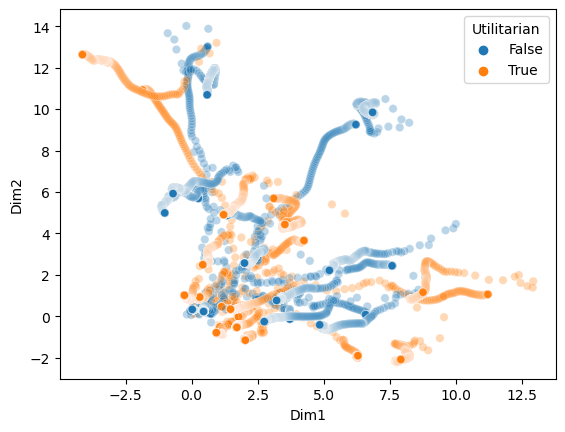

In [31]:
import seaborn as sns
sns.scatterplot(x='Dim1', y='Dim2', hue='Utilitarian', alpha = 0.3, data=dfPlot)

<Axes: xlabel='Dim1', ylabel='Dim2'>

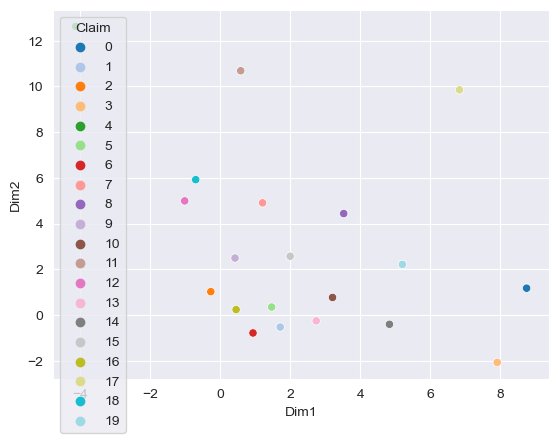

In [100]:
sns.scatterplot(x='Dim1', y='Dim2', hue='Claim', palette='tab20', data=dfPlot[dfPlot["Epoch"] == max(dfPlot["Epoch"])])

In [137]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfPlot[dfPlot["Epoch"] == max(dfPlot["Epoch"])][["Dim1", "Dim2"]])

In [138]:
distances, indices = nbrs.kneighbors(dfPlot[dfPlot["Epoch"] == max(dfPlot["Epoch"])][["Dim1", "Dim2"]])

In [139]:
for i in range(indices.shape[0]):
    print([lTargetStrings[i] for i in indices[i, :].tolist()])

['Boost Your Immunity with Every Spoonful.', 'Strengthen Your Gut with Live Cultures.', 'Heavenly Taste in Every Spoonful.']
['Packed with Probiotics for a Healthier You.', 'Feel Energized with Protein-Rich Yoghurt.', 'Daily Dose of Calcium for Strong Bones.']
['Nourish Your Body with Natural Goodness.', 'Gourmet Flavors to Satisfy Your Cravings.', 'Supports Heart Health with Omega-3s.']
['Strengthen Your Gut with Live Cultures.', 'Boost Your Immunity with Every Spoonful.', 'Experience the Silky Smooth Perfection.']
['Low in Sugar, High in Vital Nutrients.', 'Rich, Velvety Texture in Every Bite.', 'Treat Your Taste Buds to Luxurious Bliss.']
['Daily Dose of Calcium for Strong Bones.', 'Packed with Probiotics for a Healthier You.', 'Gourmet Flavors to Satisfy Your Cravings.']
['Feel Energized with Protein-Rich Yoghurt.', 'Packed with Probiotics for a Healthier You.', 'Gourmet Flavors to Satisfy Your Cravings.']
['Healthy Digestion Starts Here.', 'Treat Your Taste Buds to Luxurious Bliss

In [106]:
lTargetStrings[12], lTargetStrings[18]

('Taste the Burst of Real Fruit Flavor.',
 'Treat Your Taste Buds to Luxurious Bliss.')

In [109]:
lTargetStrings[1], lTargetStrings[7], lTargetStrings[5]

('Packed with Probiotics for a Healthier You.',
 'Healthy Digestion Starts Here.',
 'Daily Dose of Calcium for Strong Bones.')

In [108]:
lTargetStrings[3], lTargetStrings[0]

('Strengthen Your Gut with Live Cultures.',
 'Boost Your Immunity with Every Spoonful.',
 'Daily Dose of Calcium for Strong Bones.')

<Axes: xlabel='Dim1', ylabel='Dim2'>

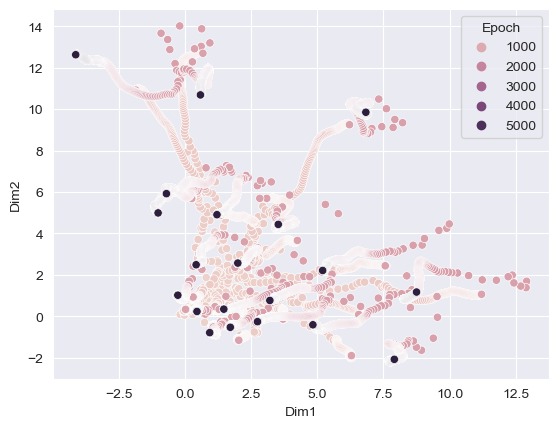

In [98]:
sns.scatterplot(x='Dim1', y='Dim2', hue='Epoch', data=dfPlot)

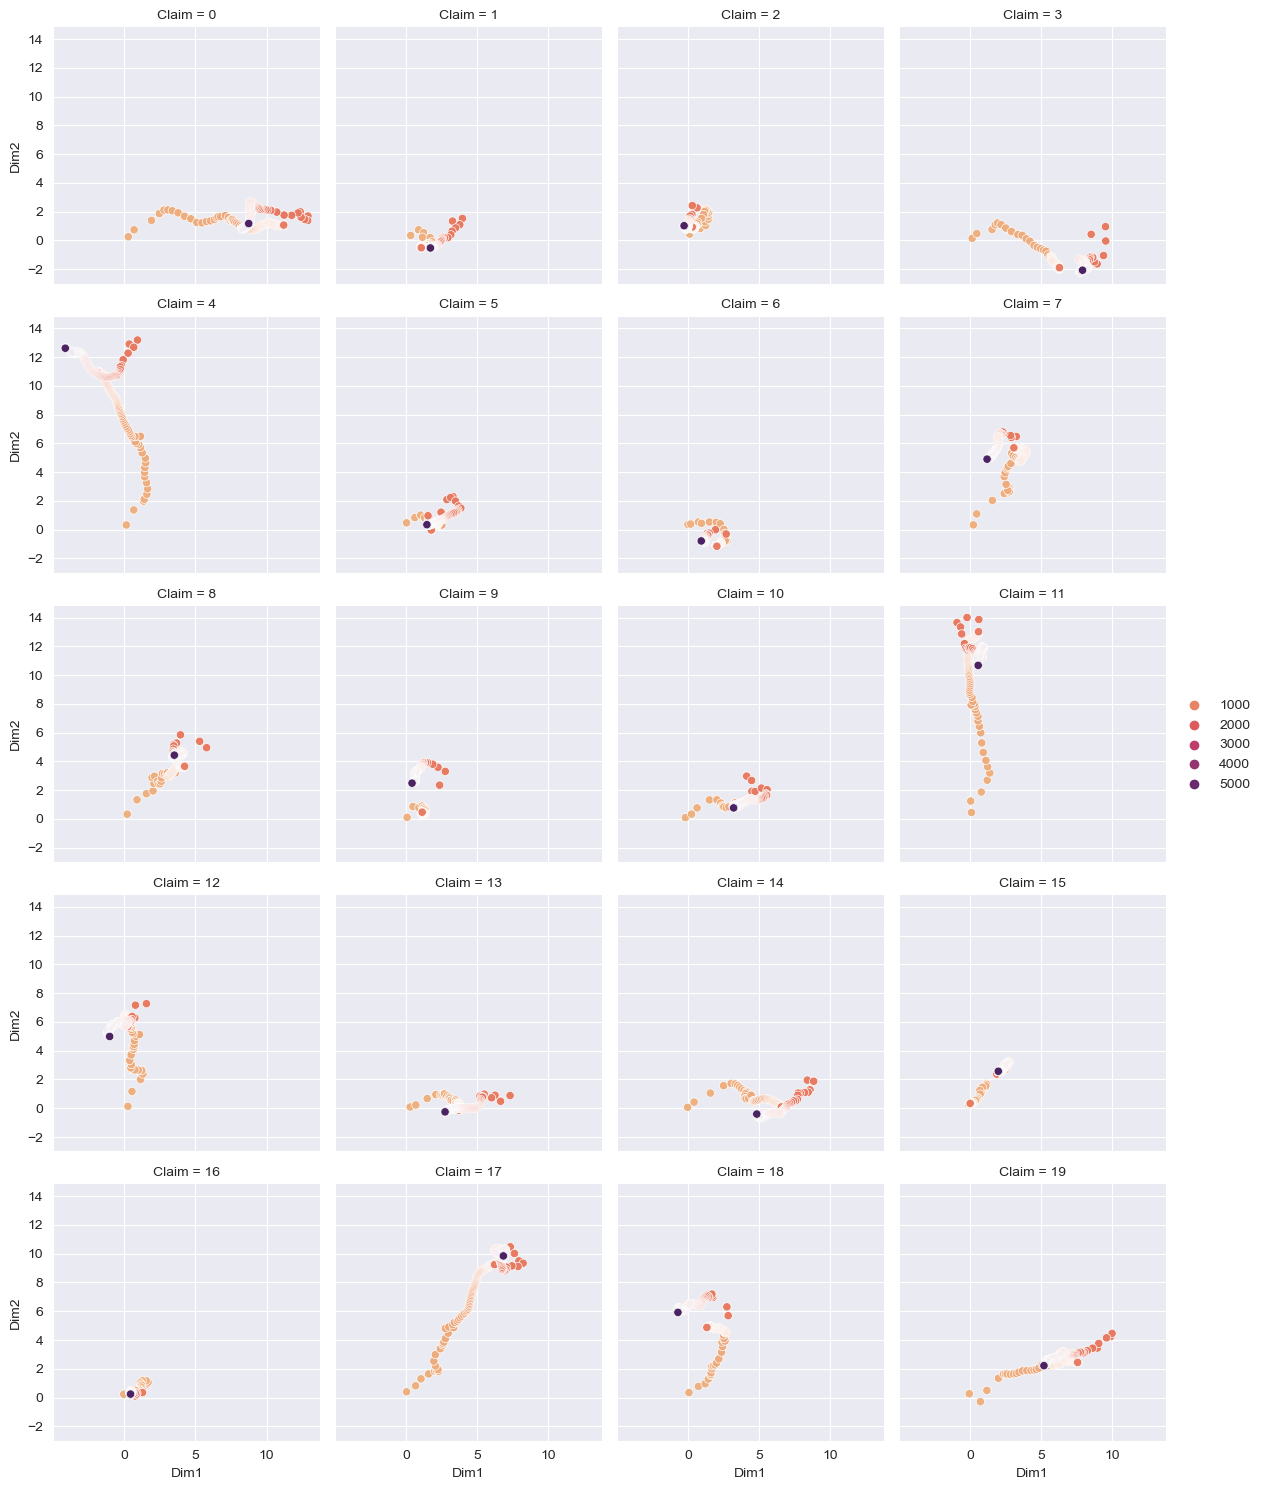

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming dfPlot is your DataFrame and iClaim contains the maximum value of 'Claim'
g = sns.FacetGrid(dfPlot[dfPlot['Claim'] <= iClaims], col="Claim", col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x='Dim1', y='Dim2', hue='Epoch', hue_norm=(min(dfPlot['Epoch']), max(dfPlot['Epoch'])), palette = 'flare', marker = "o")

# Adjust the legend for clarity
g.add_legend()
#g.set(xlim=(-8, 2), ylim=(-2, 8))

# Display the plots
plt.show()

/Users/hoener/miniforge3/envs/mphil/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/hoener/miniforge3/envs/mphil/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Dim1', ylabel='Dim2'>

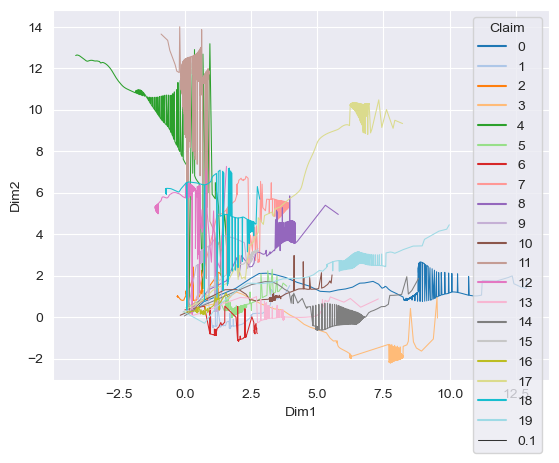

In [80]:
sns.lineplot(x='Dim1', y='Dim2', hue = "Claim", data=dfPlot, palette='tab20', size = 0.1)

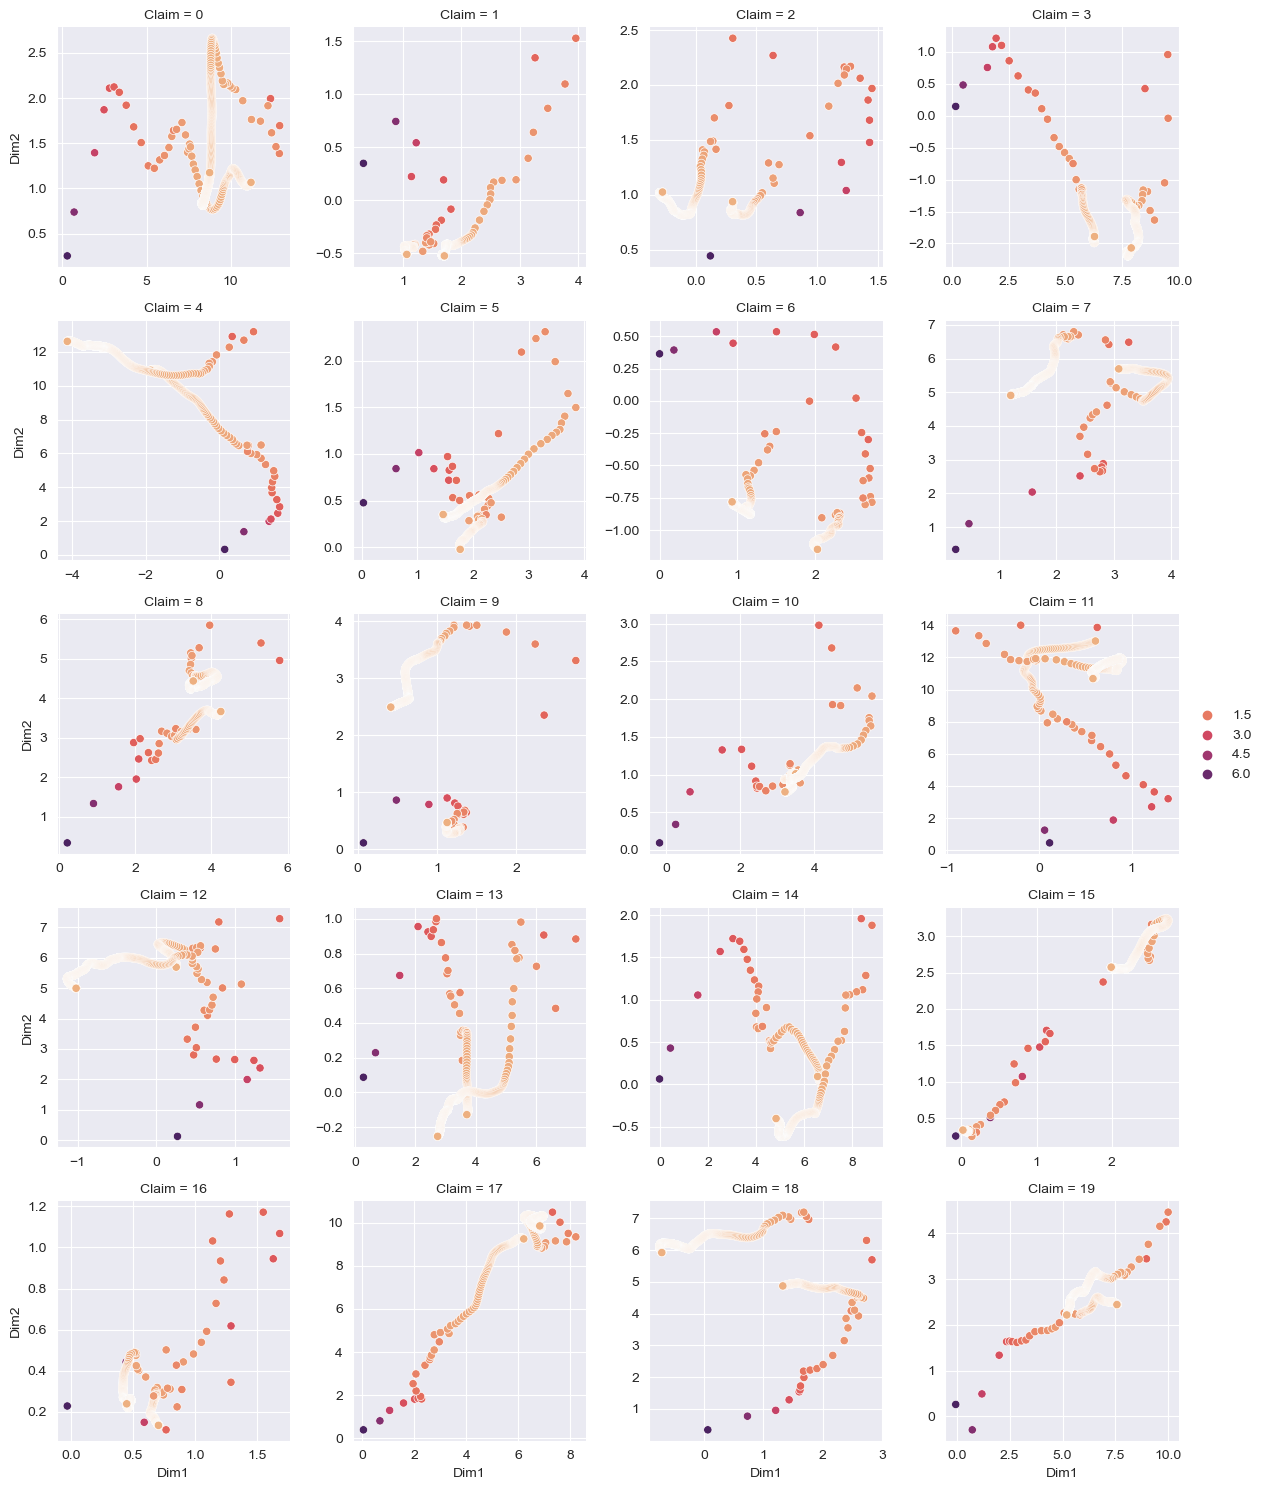

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming dfPlot is your DataFrame and iClaim contains the maximum value of 'Claim'
g = sns.FacetGrid(dfPlot[dfPlot['Claim'] <= iClaims], col="Claim", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x='Dim1', y='Dim2', hue='NLL', marker = "o", palette = 'flare')

# Adjust the legend for clarity
g.add_legend()
#g.set(xlim=(-8, 2), ylim=(-2, 8))

# Display the plots
plt.show()


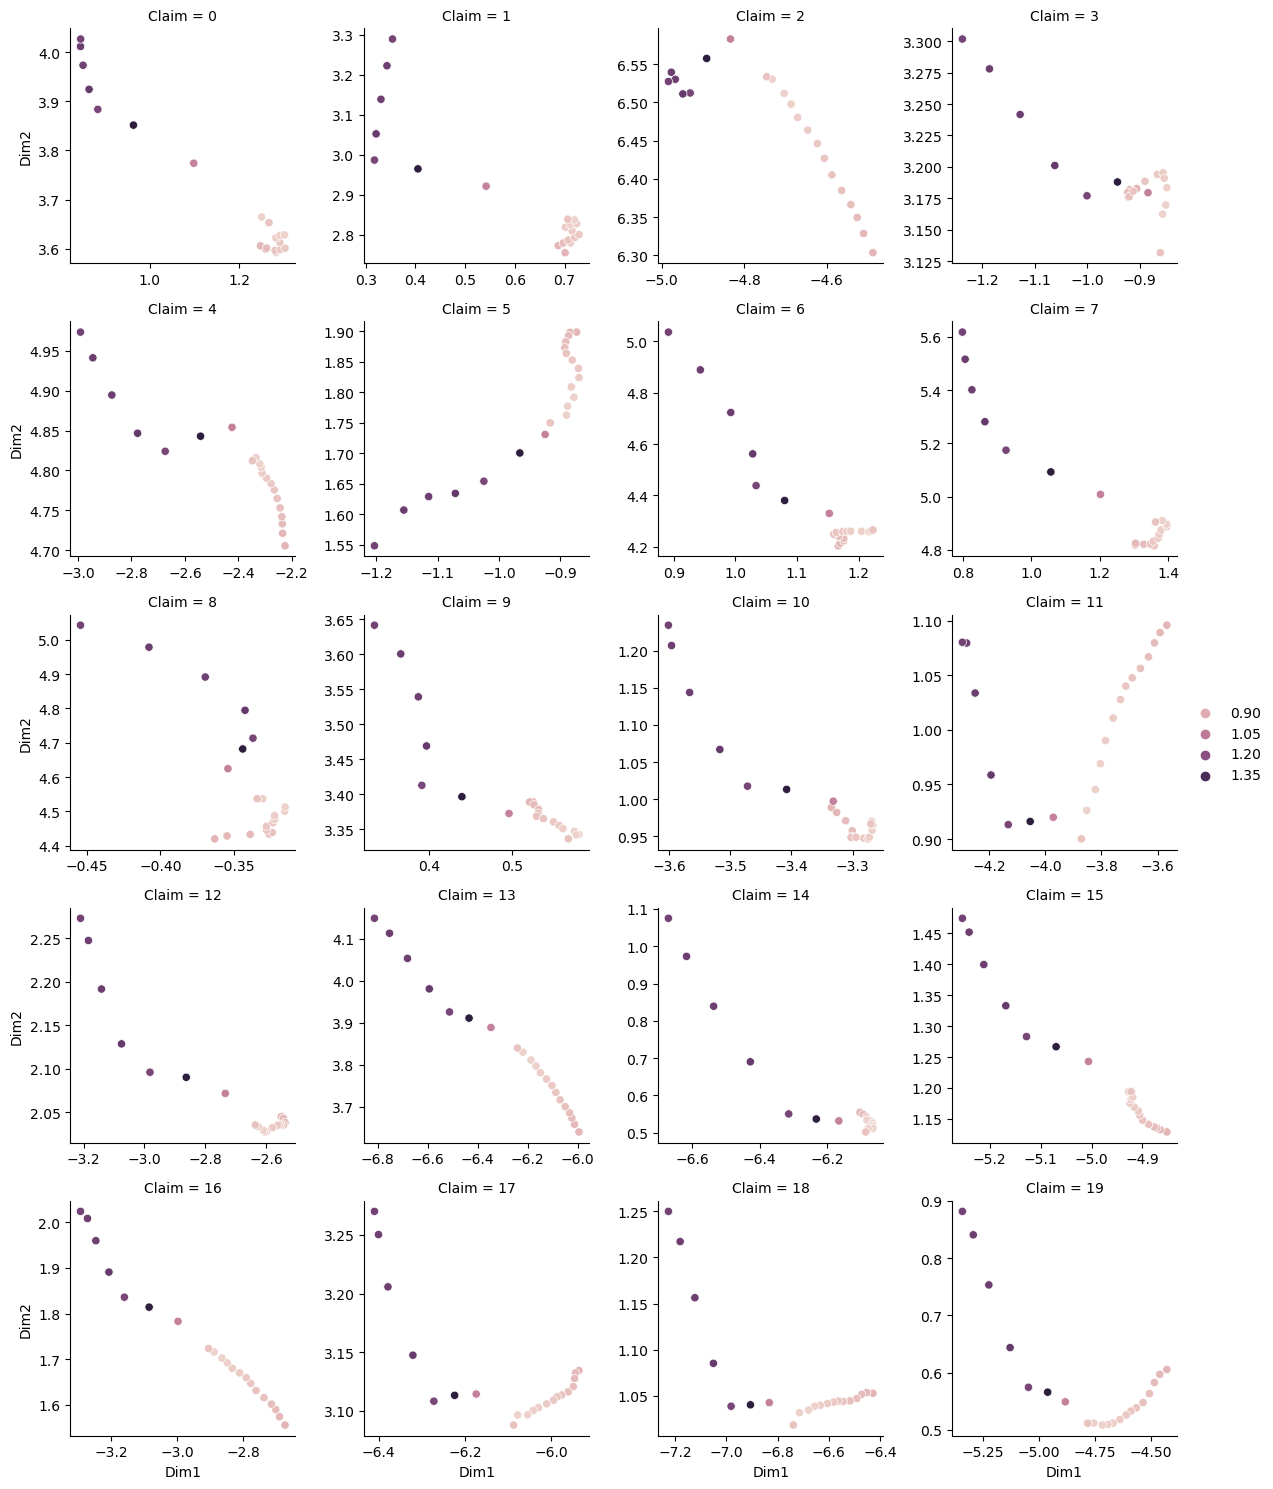

In [580]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming dfPlot is your DataFrame and iClaim contains the maximum value of 'Claim'
g = sns.FacetGrid(dfPlot[(dfPlot['Epoch'] >= 150) & (dfPlot['Epoch'] <= 170)], col="Claim", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x='Dim1', y='Dim2', hue='NLL')

# Adjust the legend for clarity
g.add_legend()


# Display the plots
plt.show()


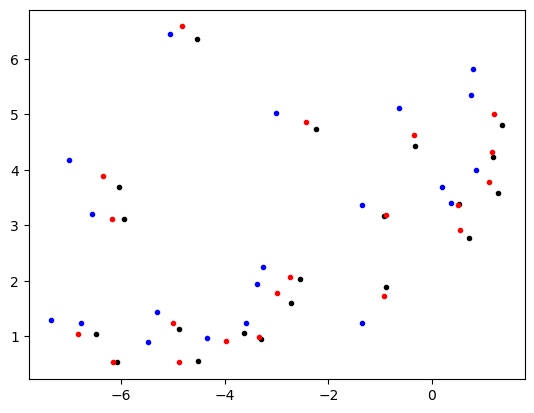

In [503]:
plt.plot(aEmbedsOld[:, 0], aEmbedsOld[:, 1], '.', c = "black")
plt.plot(aEmbeds[:, 0], aEmbeds[:, 1], '.', c = "red")
plt.plot(aEmbedsNew[:, 0], aEmbedsNew[:, 1], '.', c = "blue")

In [9]:
def ForwardPass(tOHETarget, tInputEmbeddings, tTarget, llm, ae, iBatchSize):
        tSummaryEmbedding = ae(tOHETarget).unsqueeze(1)
        tInputs = torch.cat([tSummaryEmbedding, tInputEmbeddings], dim=1)
        
        # NOTE: Necessary to keep making use of batching of the LLM, otherwise runs sequential ...
        loss = torch.tensor([0], dtype=torch.float32, requires_grad=True)
        for i, b in enumerate(range(0, iClaims, iBatchSize)):
            # NOTE: What if we exceed dim?, unit test
            out = llm(inputs_embeds = tInputs[b:((i + 1)*iBatchSize), :, :], labels=tTarget[b:((i + 1)*iBatchSize), :])
            loss = loss + out[0]
        del out
        return loss.item() # use item() to save memory

In [10]:
def EditParameters(dValue, tAEParam, i = None, j = None):
    
    if j is not None:
        tAEParam.data[i, j] += dValue
    elif i is not None:
        tAEParam.data[i] += dValue
    else:
        tAEParam.data += dValue
        print(tAEParam.data)

def ResetParameters(dValue, tAEParam, i = None, j = None):
    
    if j is not None:
        tAEParam.data[i, j] -= dValue
    elif i is not None:
        tAEParam.data[i] -= dValue
    else:
        tAEParam.data -= dValue

def RangeForwardPass(vRange, tAEParam, AE, i, j, fnForwardPass):
    vRangeLoss = torch.ones(vRange.shape[0]) - 1

    for r, R in enumerate(vRange):
        EditParameters(R, tAEParam, i, j)
        vRangeLoss[r] = fnForwardPass(AE)
        ResetParameters(R, tAEParam, i, j)
    
    return vRangeLoss

In [11]:
import copy
from tqdm import tqdm

def EvaluateLL(tAEParam, AE, vRange, fnForwardPass):

    if tAEParam.dim() == 2:
        tEval = torch.ones((vRange.size(0), tAEParam.shape[0], tAEParam.shape[1])) - 1
        for i in tqdm(range(tAEParam.shape[0])):
            for j in range(tAEParam.shape[1]):
                tEval[:, i, j] = RangeForwardPass(vRange, tAEParam, AE, i, j, fnForwardPass)

    elif tAEParam.dim() == 1:
        tEval = torch.ones((vRange.size(0), tAEParam.shape[0])) - 1
        for i in tqdm(range(tAEParam.shape[0])):
            tEval[:, i] = RangeForwardPass(vRange, tAEParam, AE, i, None, fnForwardPass)

    else:
        tEval = RangeForwardPass(vRange, tAEParam, AE, None, None, fnForwardPass)

    return tEval

def ManipulateAE(AE, tAEParam, vRange, sParameters, fnForwardPass):
    
    if sParameters == "EncoderWeights":
        #tAEParam = AEEdit.encoder[0].weight
        tEval = EvaluateLL(tAEParam, AE, vRange, fnForwardPass)
        
    elif sParameters == "DecoderWeights":
        #tAEParam = AEEdit.decoder[0].weight
        tEval = EvaluateLL(tAEParam, AE, vRange, fnForwardPass)
    
    elif sParameters == "EncoderBias":
        #tAEParam = AEEdit.encoder[0].bias
        tEval = EvaluateLL(tAEParam, AE, vRange, fnForwardPass)
    
    elif sParameters == "DecoderBias":
        #tAEParam = AEEdit.decoder[0].bias
        tEval = EvaluateLL(tAEParam, AE, vRange, fnForwardPass)
        
    else:
        raise ValueError("Invalid parameter")
    
    return tEval

In [12]:
fnForwardPass = lambda x: ForwardPass(tOHETarget, tInputEmbeddings, tTarget, model, x, iBatchSize)

In [9]:
tStepEncoderWeight
tStepDecoderWeight
tStepEncoderBias
tStepDecoderBias

tensor([ 1.4640e-03,  3.5267e-03,  3.0165e-03,  2.6088e-02,  2.4521e-03,
        -1.0252e-02,  1.6544e-02, -2.8253e-03, -1.2948e-02,  6.4287e-03,
         1.4810e-02,  2.0447e-02,  4.7547e-03,  9.6371e-03, -1.0789e-02,
         3.2268e-03, -7.2267e-03, -1.5679e-03,  6.1918e-03, -1.2937e-02,
        -5.2952e-03,  2.9024e-02,  8.5549e-03, -1.1833e-02, -1.5130e-02,
        -5.9009e-04, -1.7962e-02,  5.8959e-03, -4.7182e-03, -6.4416e-03,
        -2.3169e-02,  1.5288e-03, -1.4387e-02,  7.9461e-03, -1.1707e-02,
         7.7653e-03, -4.1027e-03,  3.8502e-02,  2.1473e-03,  5.4154e-03,
         8.2672e-03, -2.0474e-04, -2.4662e-02,  9.2947e-04,  8.5819e-04,
        -1.4823e-02, -2.8620e-02, -3.2306e-03, -2.0807e-02,  3.0469e-02,
         2.0183e-02,  1.1577e-02,  5.3539e-03, -9.3131e-03, -1.5606e-02,
         2.1378e-02, -3.2605e-03, -9.3132e-03,  1.5685e-02, -2.3335e-03,
         8.8972e-03, -1.2372e-02, -1.8719e-02, -1.2946e-03,  9.3160e-03,
         1.1614e-02, -2.8869e-03,  1.2608e-03, -5.1

In [10]:
tStepEncoderWeight

tensor([[ 0.0231, -0.0065, -0.0069,  0.0023, -0.0065, -0.0201,  0.0101, -0.0130,
          0.0028, -0.0031,  0.0056, -0.0129, -0.0034, -0.0154, -0.0007,  0.0117,
         -0.0101, -0.0027, -0.0177, -0.0207],
        [-0.0086,  0.0048,  0.0062, -0.0276, -0.0010, -0.0097,  0.0070, -0.0026,
          0.0031, -0.0026, -0.0004, -0.0229,  0.0051,  0.0130, -0.0058,  0.0032,
          0.0107, -0.0055, -0.0103,  0.0027]], device='mps:0')

In [9]:
# likeinhood for iEpoch and iEpoch + 1
fnForwardPass(ae), fnForwardPass(ae_new)

(1.0270086526870728, 1.4227309226989746)

In [20]:
# can replicate the spike like this, as long as ae is not changed beforehand
aeCopy = copy.deepcopy(ae)

aeCopy.encoder[0].weight.data = ae.encoder[0].weight.data + tStepEncoderWeight
aeCopy.encoder[0].bias.data = ae.encoder[0].bias.data + tStepEncoderBias
aeCopy.decoder[0].weight.data = ae.decoder[0].weight.data + tStepDecoderWeight
aeCopy.decoder[0].bias.data = ae.decoder[0].bias.data + tStepDecoderBias

In [11]:
tLL = torch.empty_like(tStepEncoderWeight)
tLL

tensor([[0.0000e+00, 1.4013e-45, 0.0000e+00, 3.5873e-43, 9.1835e-41, 2.3694e-38,
         2.3510e-38, 2.3510e-38, 1.4013e-45, 3.6013e-43, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.3694e-38, 3.6013e-43, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.3694e-38, 1.4013e-45],
        [0.0000e+00, 0.0000e+00, 2.3694e-38, 2.3694e-38, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.3694e-38, 9.2196e-41, 0.0000e+00, 0.0000e+00, 2.3694e-38,
         2.3694e-38, 3.6013e-43, 0.0000e+00, 0.0000e+00, 2.3694e-38, 2.3694e-38,
         1.4013e-45, 0.0000e+00]], device='mps:0')

In [17]:
tStepEncoderBias.shape

torch.Size([2])

In [7]:
ae.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=768, bias=True)
  )
)

In [10]:
tLLEncoderBias = torch.empty_like(tStepEncoderBias)
aeCopy = ae

for i in tqdm(range(tStepEncoderBias.shape[0])):
    for j in range(1):
        # reset the parameters
        aeCopy = copy.deepcopy(ae)

        # edit the parameters
        aeCopy.encoder[0].bias.data[i] = ae.encoder[0].bias.data[i] + tStepEncoderBias[i]
        # calculate the likelihh
        tLLEncoderBias[i] = fnForwardPass(aeCopy)
        

  0%|          | 0/2 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


In [11]:
tLLDecoderBias = torch.empty_like(tStepDecoderBias)
aeCopy = ae

for i in tqdm(range(tStepDecoderBias.shape[0])):
    for j in range(1):
        # reset the parameters
        aeCopy = copy.deepcopy(ae)

        # edit the parameters
        aeCopy.decoder[0].bias.data[i] = ae.decoder[0].bias.data[i] + tStepDecoderBias[i]
        # calculate the likelihh
        tLLDecoderBias[i] = fnForwardPass(aeCopy)

100%|██████████| 768/768 [01:41<00:00,  7.55it/s]


In [12]:
tLLEncoderWeight = torch.empty_like(tStepEncoderWeight)
aeCopy = ae
aeCopy.eval()

for i in tqdm(range(tStepEncoderBias.shape[0])):
    for j in range(tStepEncoderWeight.shape[1]):
        # reset the parameters
        aeCopy = copy.deepcopy(ae)

        # edit the parameters
        aeCopy.encoder[0].weight.data[i, j] = ae.encoder[0].weight.data[i, j] + tStepEncoderWeight[i, j]
        # calculate the likelihh
        tLLEncoderWeight[i, j] = fnForwardPass(aeCopy)

100%|██████████| 2/2 [00:05<00:00,  2.59s/it]


In [13]:
tLLDecoderWeight = torch.empty_like(tStepDecoderWeight)
aeCopy = ae
aeCopy.eval()

for i in tqdm(range(tStepDecoderWeight.shape[0])):
    for j in range(tStepDecoderWeight.shape[1]):
        # reset the parameters
        aeCopy = copy.deepcopy(ae)

        # edit the parameters
        aeCopy.decoder[0].weight.data[i, j] = ae.decoder[0].weight.data[i, j] + tStepDecoderWeight[i, j]
        # calculate the likelihh
        tLLDecoderWeight[i, j] = fnForwardPass(aeCopy)

100%|██████████| 768/768 [03:21<00:00,  3.82it/s]


In [14]:
fnForwardPass(ae)

1.0270086526870728

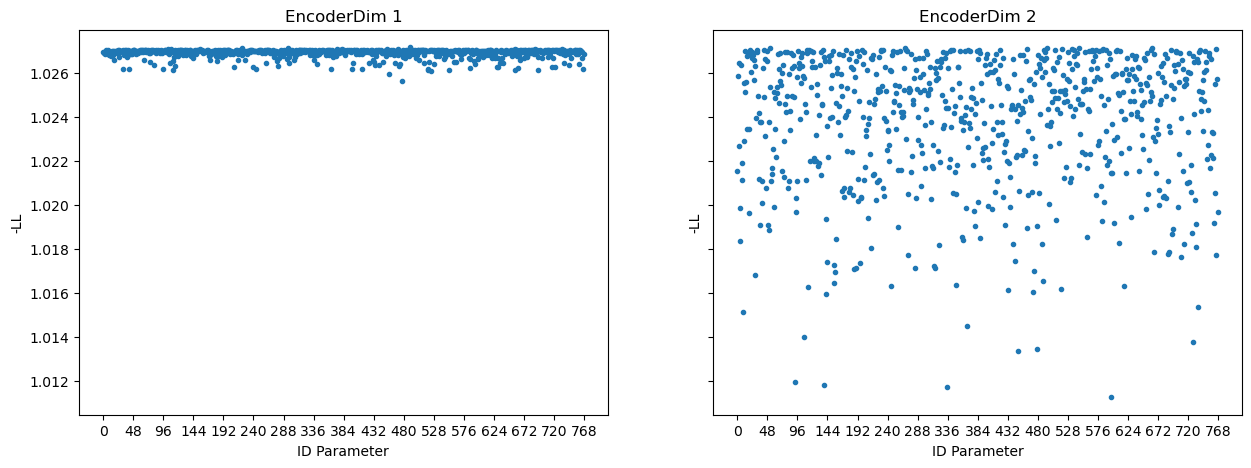

In [75]:
import matplotlib.pyplot as plt
a = tLLDecoderWeight.detach().cpu().numpy()
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
for i in range(a.shape[1]):
    ax[i].plot(np.arange(a.shape[0]), a[:, i], '.')
    ax[i].set_title(f"EncoderDim {i + 1}")
    ax[i].set_xlabel("ID Parameter")
    ax[i].set_ylabel("-LL")
    ax[i].set_xticks(range(0, 769, 48))

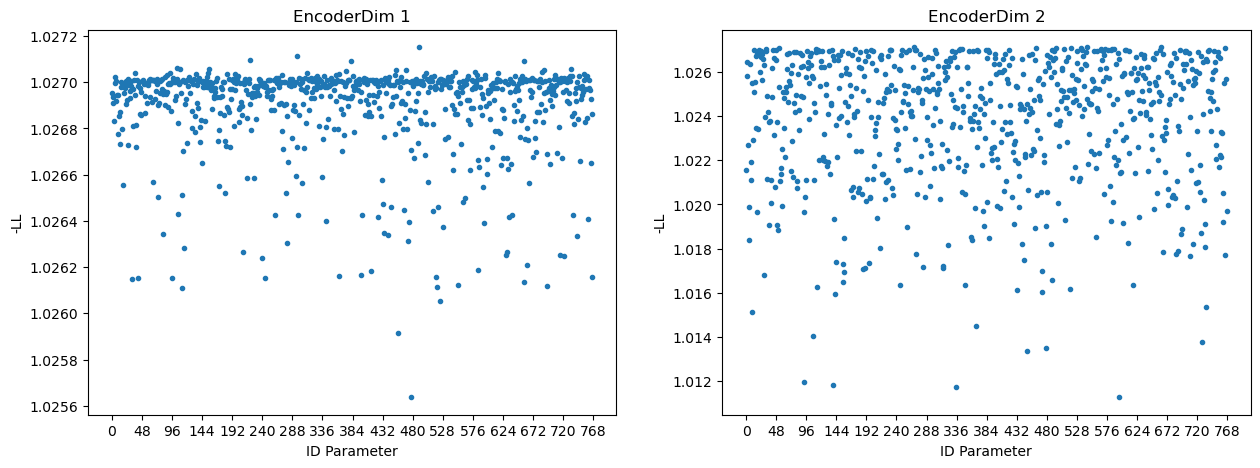

In [73]:
import matplotlib.pyplot as plt
a = tLLDecoderWeight.detach().cpu().numpy()
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=False, sharex=True)
for i in range(a.shape[1]):
    ax[i].plot(np.arange(a.shape[0]), a[:, i], '.')
    ax[i].set_title(f"EncoderDim {i + 1}")
    ax[i].set_xlabel("ID Parameter")
    ax[i].set_ylabel("-LL")
    ax[i].set_xticks(range(0, 769, 48))

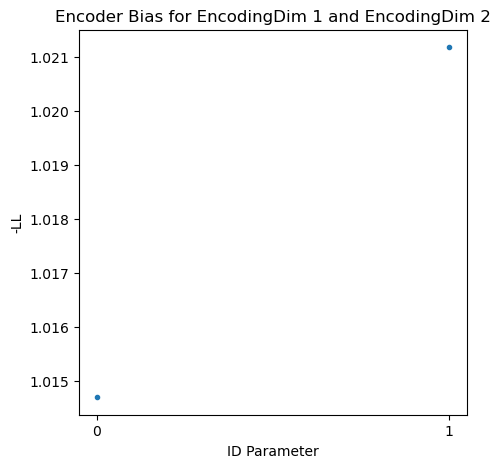

In [71]:
import matplotlib.pyplot as plt
a = tLLEncoderBias.detach().cpu().numpy()

fig, ax = plt.subplots(1, figsize = (5, 5), sharey=True, sharex=True)

ax.plot(np.arange(a.shape[0]), a, '.')
ax.set_title(f"Encoder Bias for EncodingDim 1 and EncodingDim 2")
ax.set_xlabel("ID Parameter")
ax.set_ylabel("-LL")
ax.set_xticks(range(0, 2, 1))

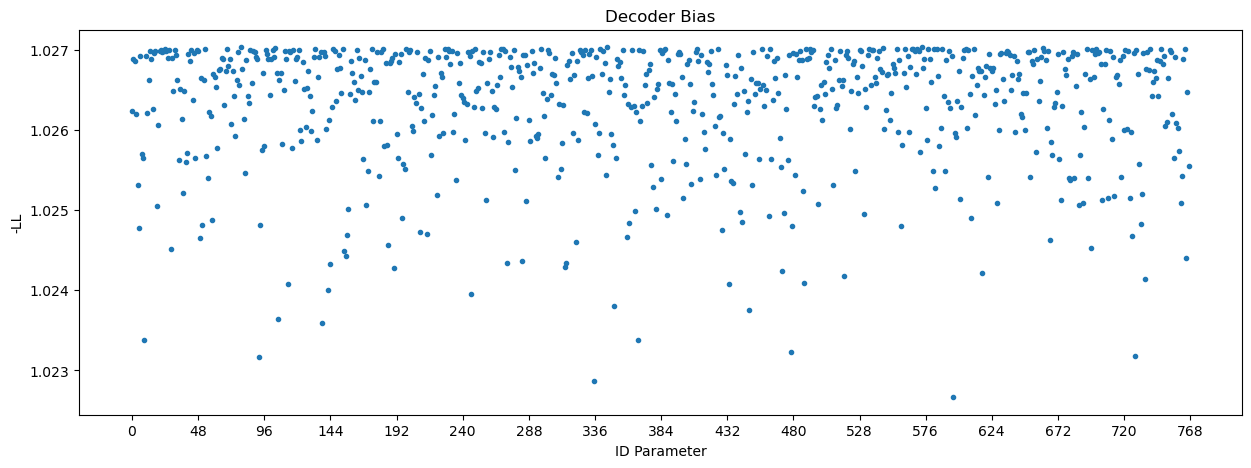

In [74]:
import matplotlib.pyplot as plt
a = tLLDecoderBias.detach().cpu().numpy()

fig, ax = plt.subplots(1, figsize = (15, 5), sharey=True, sharex=True)

ax.plot(np.arange(a.shape[0]), a, '.')
ax.set_title(f"Decoder Bias")
ax.set_xlabel("ID Parameter")
ax.set_ylabel("-LL")
ax.set_xticks(range(0, 769, 48))

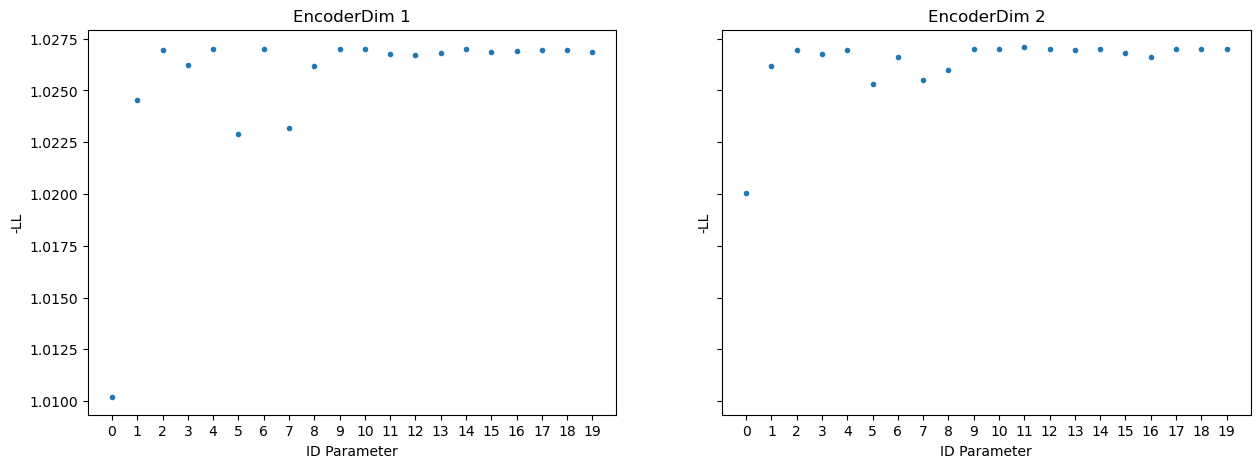

In [67]:
import matplotlib.pyplot as plt
a = tLLEncoderWeight.detach().cpu().numpy()
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
for i in range(a.shape[0]):
    ax[i].plot(np.arange(a.shape[1]), a[i, :], '.')
    ax[i].set_title(f"EncoderDim {i + 1}")
    ax[i].set_xlabel("ID Parameter")
    ax[i].set_ylabel("-LL")
    ax[i].set_xticks(range(20))

In [63]:
torch.max(tStepEncoderBias), torch.min(tStepEncoderBias)

(tensor(0.0328, device='mps:0'), tensor(-0.0713, device='mps:0'))

In [69]:
tRange = torch.arange(-0.08, 0.08 + 0.001, 0.02)
tRange

tensor([-0.0800, -0.0600, -0.0400, -0.0200,  0.0000,  0.0200,  0.0400,  0.0600,
         0.0800], device='mps:0')

In [13]:
def arange(dValue):
    
    dStep = dValue / 10
    tReturn = torch.arange(0, dValue + dStep, dStep)

    if tReturn.shape[0] == 12:
        return tReturn[0:-1]
    return tReturn

In [228]:
arange(tStepEncoderBias[i]), torch.ones(11) * 1.6638

(tensor([0.0000, 0.0033, 0.0066, 0.0098, 0.0131, 0.0164, 0.0197, 0.0230, 0.0262,
         0.0295, 0.0328], device='mps:0'),
 tensor([1.6638, 1.6638, 1.6638, 1.6638, 1.6638, 1.6638, 1.6638, 1.6638, 1.6638,
         1.6638, 1.6638], device='mps:0'))

In [8]:
aeNew = Autoencoder(20, 2, 768)
aeNew.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
AEEdit.encoder[0].bias.data[0]

tensor(-1.7928, device='mps:0')

In [78]:
from tqdm import tqdm

def EvalJointBias(tStepBias, sParameterID, ddParameterDict, fnAE):

    # joint steps
    ddParameterDictEdit = copy.deepcopy(ddParameterDict)
    tStep = torch.ones(arange(tStepBias[0]).shape[0], tStepBias.shape[0]) - 1
    
    for i in range(tStepBias.shape[0]):
        tStep[:, i] = arange(tStepBias[i])
    
    tEval = torch.ones((tStep.shape[0])) - 1
    for i, step in tqdm(enumerate(tStep)):
        ddParameterDictEdit = copy.deepcopy(ddParameterDict)
        ddParameterDictEdit[sParameterID] = ddParameterDict[sParameterID] + step
        AEEdit = fnAE
        AEEdit.load_state_dict(ddParameterDictEdit)
        tEval[i] = fnForwardPass(AEEdit)
        
    return tEval, tStep

def EvalMarginalBias(tStepBias, sParameterID, ddParameterDict, fnAE):

    # joint steps
    ddParameterDictEdit = copy.deepcopy(ddParameterDict)
    tStep = torch.ones(arange(tStepBias[0]).shape[0], tStepBias.shape[0]) - 1
    
    for i in range(tStepBias.shape[0]):
        tStep[:, i] = arange(tStepBias[i])
    
    tEval = torch.ones((tStep.shape[0]), tStepBias.shape[0]) - 1
    for j in tqdm(range(tStep.shape[1])):
        for i, step in enumerate(tStep):
            ddParameterDictEdit = copy.deepcopy(ddParameterDict)
            ddParameterDictEdit[sParameterID][j] = ddParameterDict[sParameterID][j] + step[j]
            AEEdit = fnAE
            AEEdit.load_state_dict(ddParameterDictEdit)
            tEval[i, j] = fnForwardPass(AEEdit)
            
    return tEval, tStep


In [108]:
from tqdm import tqdm

def EvalJointWeight(tStepWeight, sParameterID, ddParameterDict, fnAE):

    # joint steps
    ddParameterDictEdit = copy.deepcopy(ddParameterDict)
    tStep = torch.ones(arange(tStepWeight[0, 0]).shape[0], tStepWeight.shape[0], tStepWeight.shape[1]) - 1
    
    for j in range(tStepWeight.shape[1]):
        for i in range(tStepWeight.shape[0]):
            tStep[:, i, j] = arange(tStepWeight[i, j])
    
    tEval = torch.ones(tStep.shape[0]) - 1

    for k, step in tqdm(enumerate(tStep)):
        ddParameterDictEdit = copy.deepcopy(ddParameterDict)
        ddParameterDictEdit[sParameterID] = ddParameterDict[sParameterID] + step
        AEEdit = fnAE
        AEEdit.load_state_dict(ddParameterDictEdit)
        tEval[k] = fnForwardPass(AEEdit)
                
    return tEval, tStep

def EvalMarginalWeight(tStepWeight, sParameterID, ddParameterDict, fnAE):

    # joint steps
    ddParameterDictEdit = copy.deepcopy(ddParameterDict)
    tStep = torch.ones(arange(tStepWeight[0, 0]).shape[0], tStepWeight.shape[0], tStepWeight.shape[1]) - 1
    
    for j in range(tStepWeight.shape[1]):
        for i in range(tStepWeight.shape[0]):
            tStep[:, i, j] = arange(tStepWeight[i, j])
    
    tEval = torch.ones(tStep.shape[0], tStep.shape[1], tStep.shape[2]) - 1
    
    for j in range(tStep.shape[2]):
        for i in tqdm(range(tStep.shape[1])):
            for k, step in enumerate(tStep):
                ddParameterDictEdit = copy.deepcopy(ddParameterDict)
                ddParameterDictEdit[sParameterID][i, j] = ddParameterDict[sParameterID][i, j] + step[i, j]
                AEEdit = fnAE
                AEEdit.load_state_dict(ddParameterDictEdit)
                tEval[k, i, j] = fnForwardPass(AEEdit)
                
    return tEval, tStep

11it [00:01,  6.88it/s]
100%|██████████| 20/20 [00:54<00:00,  2.74s/it]


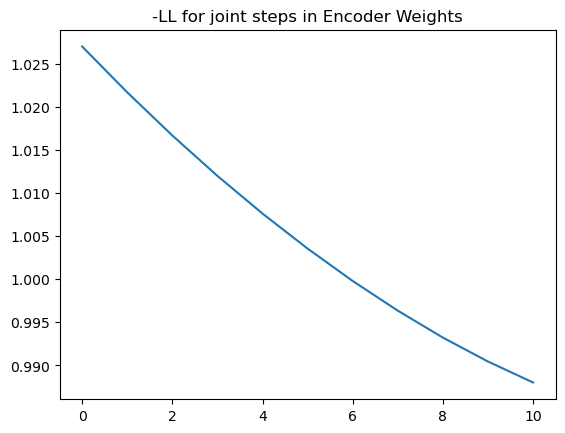

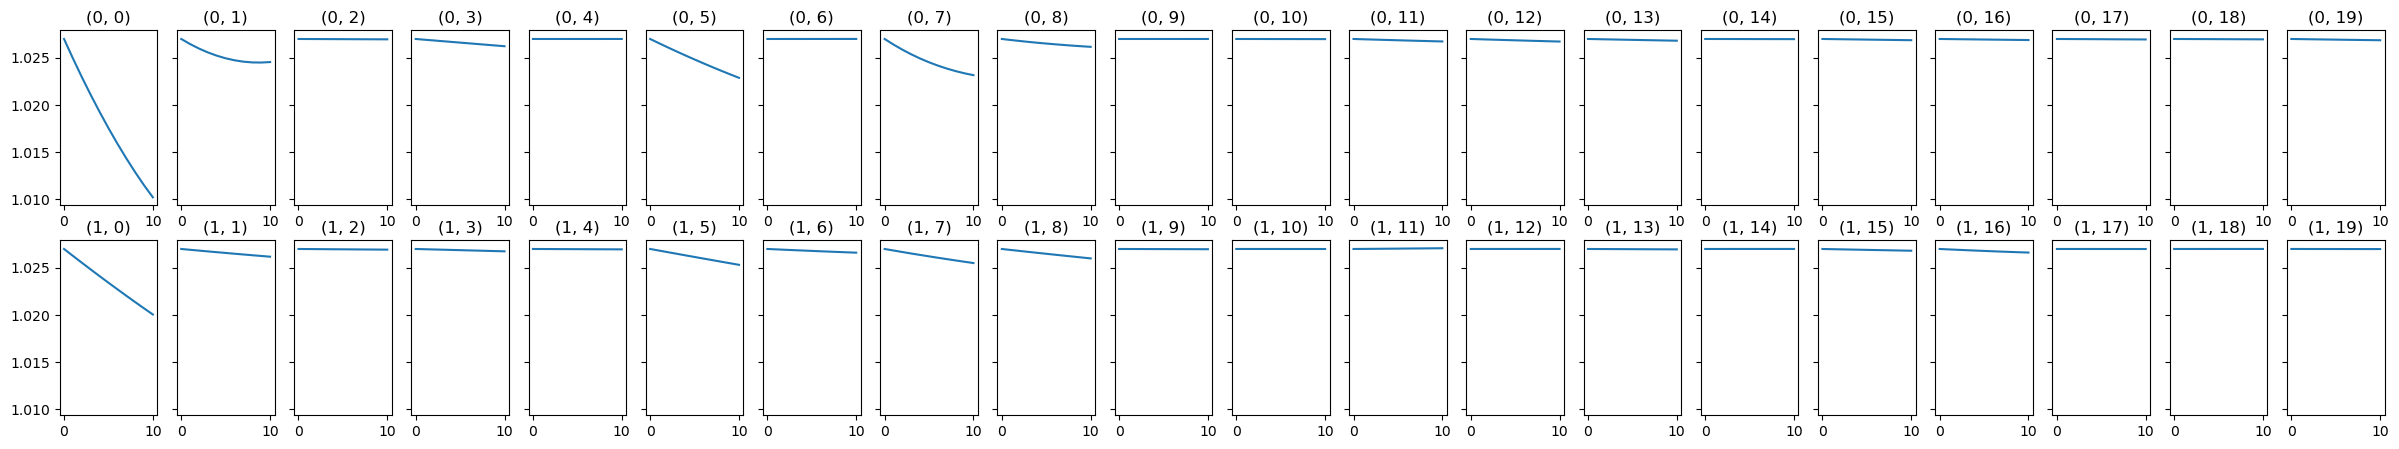

In [103]:
# Encoder Weights
tEval, tStep = EvalJointWeight(tStepEncoderWeight, "encoder.0.weight", ae.state_dict(), Autoencoder(20, 2, 768))
plt.plot(tEval.detach().cpu().numpy())
plt.title("-LL for joint steps in Encoder Weights")

tEval, tStep = EvalMarginalWeight(tStepEncoderWeight, "encoder.0.weight", ae.state_dict(), Autoencoder(20, 2, 768))
tEval.shape, tStep.shape 

fig, ax = plt.subplots(tEval.shape[1], tEval.shape[2], figsize = (30, 5), sharey=True)

for i in range(tEval.shape[1]):
    for j in range(tEval.shape[2]):
        ax[i, j].plot(tEval[:, i, j].detach().cpu().numpy())
        ax[i, j].set_title(f"{i, j}")
        #ax[i, j].set_xticks(np.arange(11), tStep.detach().cpu().numpy()[:, i, j])

11it [00:01,  6.54it/s]
  1%|          | 7/768 [00:10<18:36,  1.47s/it]


KeyboardInterrupt: 

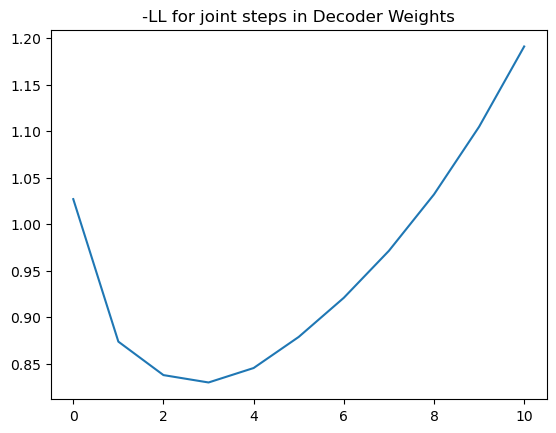

In [109]:
# Decoder Weights
tEval, tStep = EvalJointWeight(tStepDecoderWeight, "decoder.0.weight", ae.state_dict(), Autoencoder(20, 2, 768))
plt.plot(tEval.detach().cpu().numpy())
plt.title("-LL for joint steps in Decoder Weights")

tEvalDecoderWeight, tStep = EvalMarginalWeight(tStepDecoderWeight, "decoder.0.weight", ae.state_dict(), Autoencoder(20, 2, 768))
tEvalDecoderWeight.shape, tStep.shape

In [ ]:
fig, ax = plt.subplots(tEvalDecoderWeight.shape[1], tEvalDecoderWeight.shape[2], figsize = (30, 5), sharey=True)

for i in range(tEvalDecoderWeight.shape[1]):
    for j in range(tEvalDecoderWeight.shape[2]):
        ax[i, j].plot(tEvalDecoderWeight[:, i, j].detach().cpu().numpy())
        ax[i, j].set_title(f"{i, j}")
        #ax[i, j].set_xticks(np.arange(11), tStep.detach().cpu().numpy()[:, i, j])

11it [00:01,  7.61it/s]
100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


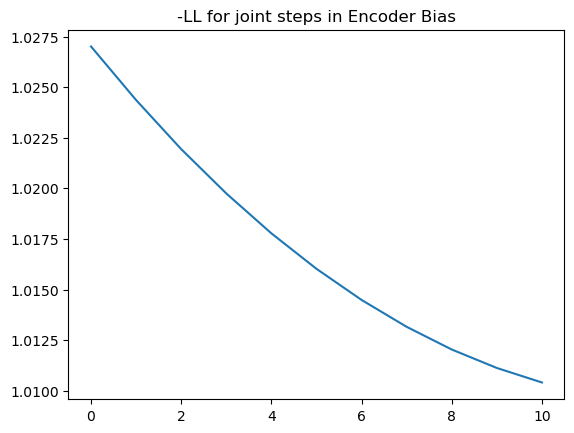

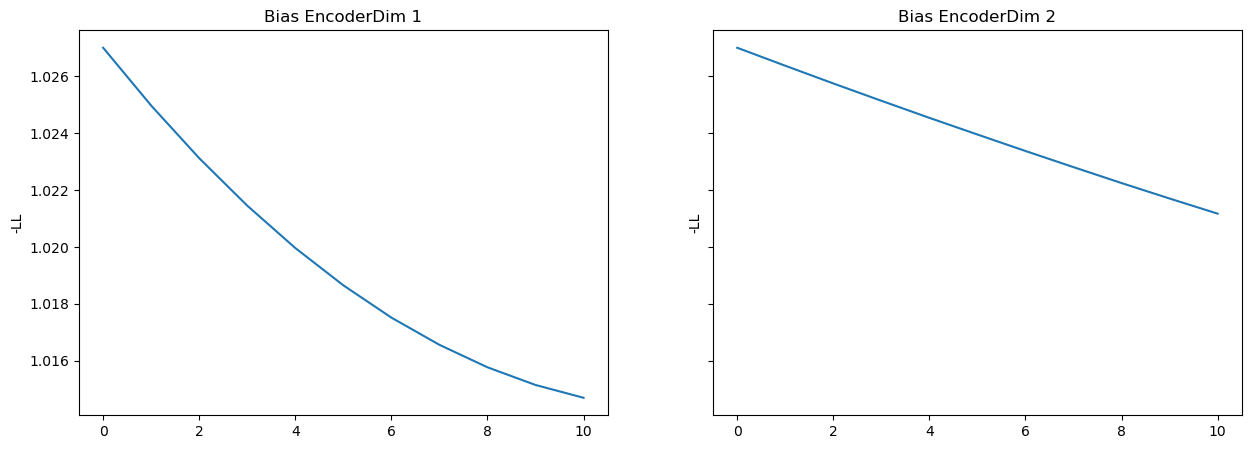

In [101]:
# Encoder Bias
tEval, tStep = EvalJointBias(tStepEncoderBias, "encoder.0.bias", ae.state_dict(), Autoencoder(20, 2, 768))
plt.plot(tEval.detach().cpu().numpy())
plt.title("-LL for joint steps in Encoder Bias")

tEval, tStep = EvalMarginalBias(tStepEncoderBias, "encoder.0.bias", ae.state_dict(), Autoencoder(20, 2, 768))
tEval.shape, tStep.shape 

fig, ax = plt.subplots(1, tEval.shape[1], figsize = (15, 5), sharey=True)

for i in range(tEval.shape[1]):
    ax[i].plot(tEval[:, i].detach().cpu().numpy())
    ax[i].set_title(f"Bias EncoderDim {i + 1}")
    ax[i].set_ylabel("-LL")
    #ax[i].set_xticks(np.arange(11), tStep.detach().cpu().numpy()[:, i])

11it [00:02,  5.39it/s]
  0%|          | 1/768 [00:02<36:00,  2.82s/it]


KeyboardInterrupt: 

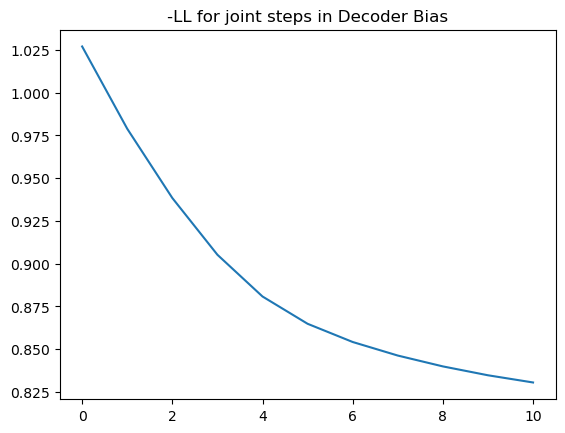

In [105]:
# Decoder Bias
tEval, tStep = EvalJointBias(tStepDecoderBias, "decoder.0.bias", ae.state_dict(), Autoencoder(20, 2, 768))
plt.plot(tEval.detach().cpu().numpy())
plt.title("-LL for joint steps in Decoder Bias")

tEvalDecoderBias, tStep = EvalMarginalBias(tStepDecoderBias, "decoder.0.bias", ae.state_dict(), Autoencoder(20, 2, 768))
tEval.shape, tStep.shape

In [ ]:
fig, ax = plt.subplots(1, tEvalDecoderBias.shape[1], figsize = (15, 5), sharey=True)

for i in range(tEvalDecoderBias.shape[1]):
    ax[i].plot(tEvalDecoderBias[:, i].detach().cpu().numpy())
    ax[i].set_title(f"Bias EncoderDim {i + 1}")
    ax[i].set_ylabel("-LL")
    #ax[i].set_xticks(np.arange(11), tStep.detach().cpu().numpy()[:, i])

In [53]:
EvalJointBias(tStepEncoderBias, "encoder.0.bias", ae.state_dict(), Autoencoder(20, 2, 768))
EvalMarginalBias(tStepEncoderBias, "encoder.0.bias", ae.state_dict(), Autoencoder(20, 2, 768))

11it [00:01,  5.68it/s]
100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


tensor([[1.0270, 1.0270],
        [1.0250, 1.0264],
        [1.0231, 1.0258],
        [1.0215, 1.0251],
        [1.0200, 1.0245],
        [1.0187, 1.0240],
        [1.0175, 1.0234],
        [1.0166, 1.0228],
        [1.0158, 1.0222],
        [1.0151, 1.0217],
        [1.0147, 1.0212]], device='mps:0')

In [55]:
EvalJointBias(tStepDecoderBias, "decoder.0.bias", ae.state_dict(), Autoencoder(20, 2, 768))
EvalMarginalBias(tStepDecoderBias, "decoder.0.bias", ae.state_dict(), Autoencoder(20, 2, 768))

11it [00:01,  6.07it/s]


In [34]:
for step in tStep:
    print(step)

tensor([0., 0.], device='mps:0')
tensor([-0.0071,  0.0033], device='mps:0')
tensor([-0.0143,  0.0066], device='mps:0')
tensor([-0.0214,  0.0098], device='mps:0')
tensor([-0.0285,  0.0131], device='mps:0')
tensor([-0.0357,  0.0164], device='mps:0')
tensor([-0.0428,  0.0197], device='mps:0')
tensor([-0.0499,  0.0230], device='mps:0')
tensor([-0.0571,  0.0262], device='mps:0')
tensor([-0.0642,  0.0295], device='mps:0')
tensor([-0.0713,  0.0328], device='mps:0')


In [33]:
tStep

tensor([[ 0.0000,  0.0000],
        [-0.0071,  0.0033],
        [-0.0143,  0.0066],
        [-0.0214,  0.0098],
        [-0.0285,  0.0131],
        [-0.0357,  0.0164],
        [-0.0428,  0.0197],
        [-0.0499,  0.0230],
        [-0.0571,  0.0262],
        [-0.0642,  0.0295],
        [-0.0713,  0.0328]], device='mps:0')

In [26]:
tRange

tensor([ 0.0000, -0.0071, -0.0143, -0.0214, -0.0285, -0.0357, -0.0428, -0.0499,
        -0.0571, -0.0642, -0.0713], device='mps:0')

In [17]:
state_dict = ae.state_dict()

tEval = torch.ones((arange(tStepEncoderBias[0]).size(0), ae.encoder[0].bias.size(0))) - 1

for i in tqdm(range(ae.encoder[0].bias.shape[0])):
    with torch.no_grad():
        AEEdit = Autoencoder(20, 2, 768)
        AEEdit.load_state_dict(state_dict)
        tEval[:, i] = ManipulateAE(AEEdit, AEEdit.encoder[0].bias[i], arange(tStepEncoderBias[i]), "EncoderBias", fnForwardPass)
        del AEEdit

  0%|          | 0/2 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tensor(-1.7928, device='mps:0')
tensor(-1.7999, device='mps:0')
tensor(-1.8071, device='mps:0')
tensor(-1.8142, device='mps:0')
tensor(-1.8213, device='mps:0')
tensor(-1.8285, device='mps:0')
tensor(-1.8356, device='mps:0')
tensor(-1.8428, device='mps:0')
tensor(-1.8499, device='mps:0')
tensor(-1.8570, device='mps:0')
tensor(-1.8642, device='mps:0')


 50%|█████     | 1/2 [00:01<00:01,  1.62s/it]

tensor(1.6638, device='mps:0')
tensor(1.6638, device='mps:0')
tensor(1.6638, device='mps:0')
tensor(1.6638, device='mps:0')
tensor(1.6638, device='mps:0')
tensor(1.6638, device='mps:0')
tensor(1.6638, device='mps:0')
tensor(1.6638, device='mps:0')
tensor(1.6638, device='mps:0')
tensor(1.6638, device='mps:0')


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]

tensor(1.6638, device='mps:0')


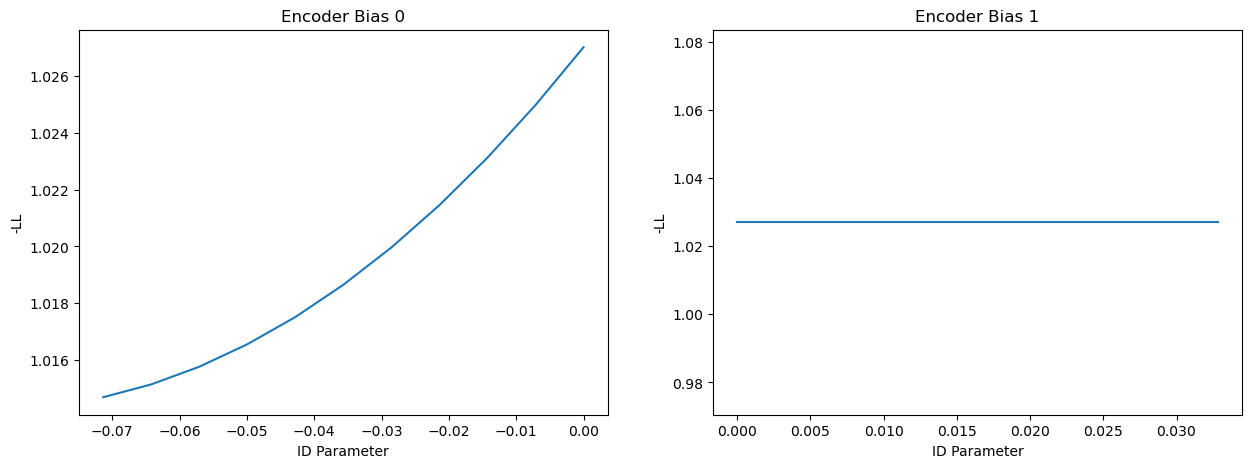

In [202]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=False, sharex=False)

for i in range(tEval.shape[1]):
    ax[i].plot(arange(tStepEncoderBias[i]).detach().cpu().numpy(), tEval[:, i].detach().cpu().numpy())
    ax[i].set_title(f"Encoder Bias {i}")
    ax[i].set_xlabel("ID Parameter")
    ax[i].set_ylabel("-LL")

In [105]:
AEEdit = copy.deepcopy(ae)

tEval = torch.ones((arange(tStepDecoderBias[i]).size(0), AEEdit.decoder[0].bias.size(0))) - 1
for i in tqdm(range(AEEdit.decoder[0].bias.shape[0])):
    AEEdit = copy.deepcopy(ae)
    with torch.no_grad():
        tEval[:, i] = ManipulateAE(AEEdit, AEEdit.decoder[0].bias[i], arange(tStepDecoderBias[i]), "DecoderBias", fnForwardPass)

100%|██████████| 768/768 [18:02<00:00,  1.41s/it]


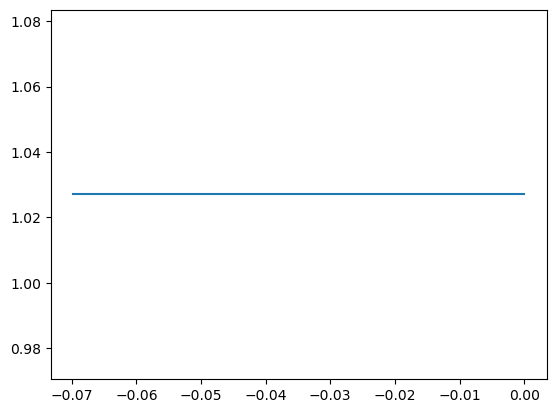

In [112]:
i = 4
plt.plot(arange(tStepDecoderBias[i]).detach().cpu().numpy(), tEval[:, i].detach().cpu().numpy())

In [14]:
tEval[tRange.detach().cpu().numpy() == 0, :]

tensor([[1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077, 1.2077,
         1.2077, 1.2077, 1.2

In [71]:
if tEval.dim() == 2:
   print(torch.max(torch.max(tEval, dim=0)[0] - tEval[tRange.detach().cpu().numpy() == 0, :]))
else:
    print(torch.max(torch.max(tEval, dim=0)[0] - tEval[tRange.detach().cpu().numpy() == 0, :, :]))


tensor(0.0101, device='mps:0')


In [72]:
torch.sum((torch.max(tEval, dim=0)[0] - tEval[tRange.detach().cpu().numpy() == 0, :]))

tensor(0.0160, device='mps:0')

- DecoderWeights max: 0.0047, -0.1 to 0.1
- EncoderWeights max: 0.0026, -0.04 to 0.04
- DecoderBias max: 
- EncoderBias max: 0.0004, -0.01 to 0.01

In [74]:
tEval.shape

torch.Size([9, 2])

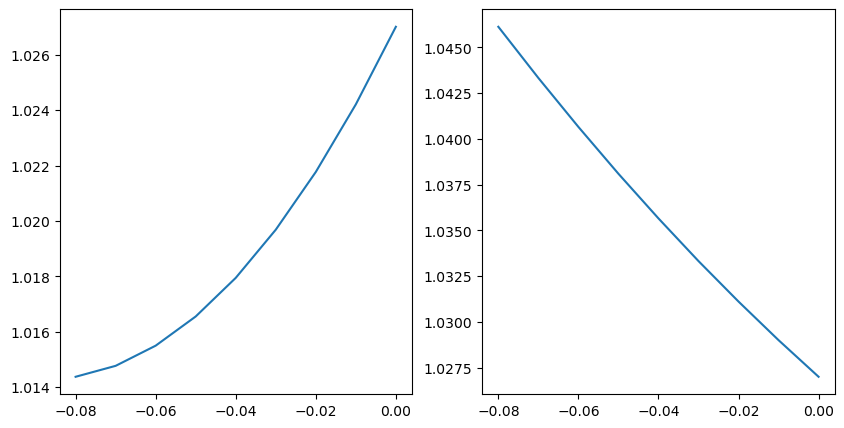

In [95]:
tEval.shape

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(tRange.detach().cpu().numpy(), tEval[:, 0].detach().cpu().numpy())
#ax[0].set_ylim([1.42, 1.43])
ax[1].plot(tRange.detach().cpu().numpy(), tEval[:, 1].detach().cpu().numpy())
#ax[1].set_ylim([1.42, 1.43])

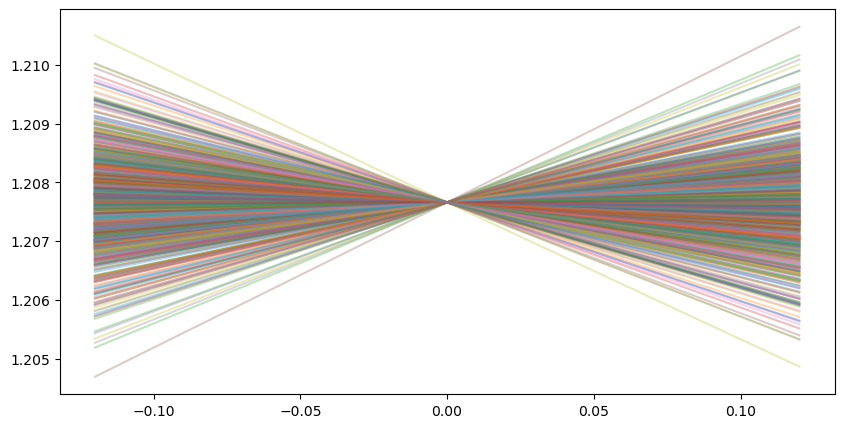

In [28]:
tEval.shape

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(tEval.shape[1]):
    ax.plot(tRange.detach().cpu().numpy(), tEval[:, i].detach().cpu().numpy(), alpha = 0.3)
    #ax[0].set_ylim([1.415, 1.420])
    #ax[1].plot(tRange.detach().cpu().numpy(), tEval[1, i].detach().cpu().numpy())
    #ax[0].set_ylim([1.415, 1.420])


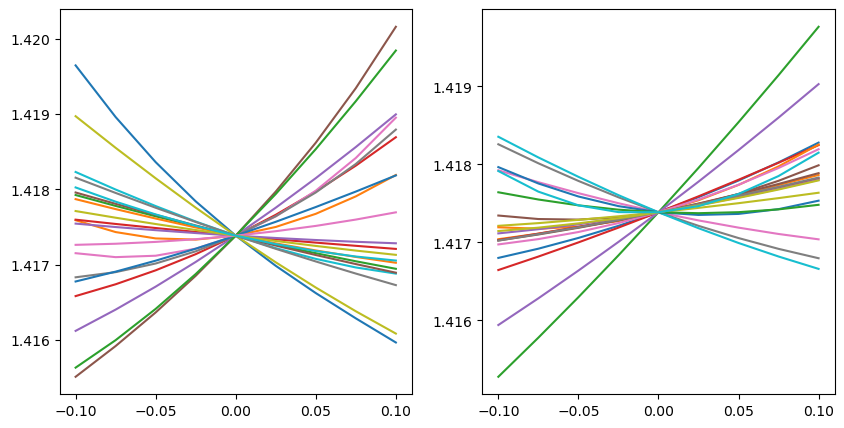

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(tEval.shape[2]):
    ax[0].plot(tRange.detach().cpu().numpy(), tEval[:, 0, i].detach().cpu().numpy(), alpha = 1)
    #ax[0].set_ylim([0.848, 0.856])
    ax[1].plot(tRange.detach().cpu().numpy(), tEval[:, 1, i].detach().cpu().numpy(), alpha = 1)
    #ax[1].set_ylim([0.848, 0.856])

In [455]:
tEval.shape

torch.Size([9, 768])

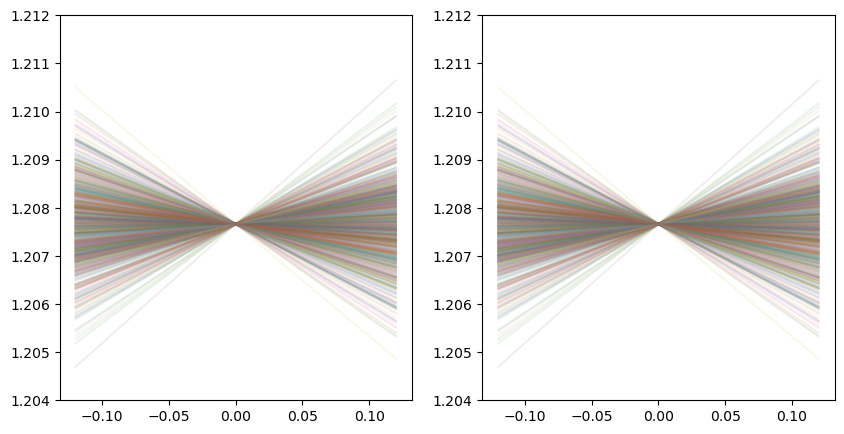

In [458]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(tEval.shape[1]):
    ax[0].plot(tRange.detach().cpu().numpy(), tEval[:, i].detach().cpu().numpy(), alpha = 0.1)
    ax[0].set_ylim([1.204, 1.212])
    ax[1].plot(tRange.detach().cpu().numpy(), tEval[:, i].detach().cpu().numpy(), alpha = 0.1)
    ax[1].set_ylim([1.204, 1.212])

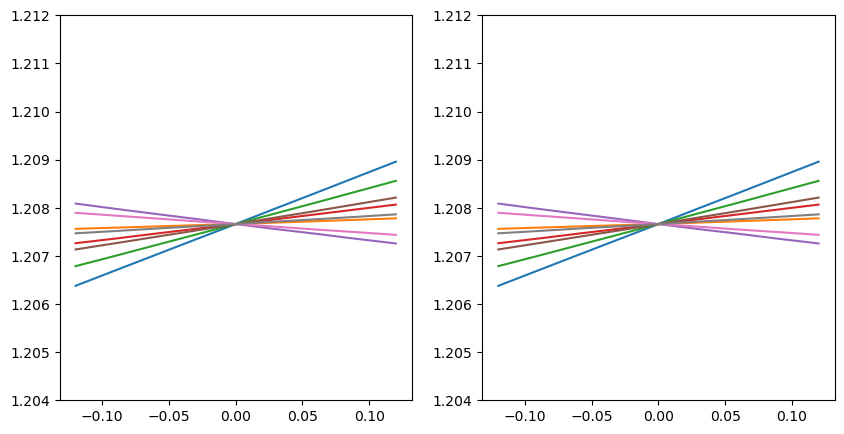

In [465]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(5, tEval.shape[1], 100):
    ax[0].plot(tRange.detach().cpu().numpy(), tEval[:, i].detach().cpu().numpy())
    ax[0].set_ylim([1.204, 1.212])
    ax[1].plot(tRange.detach().cpu().numpy(), tEval[:, i].detach().cpu().numpy())
    ax[1].set_ylim([1.204, 1.212])

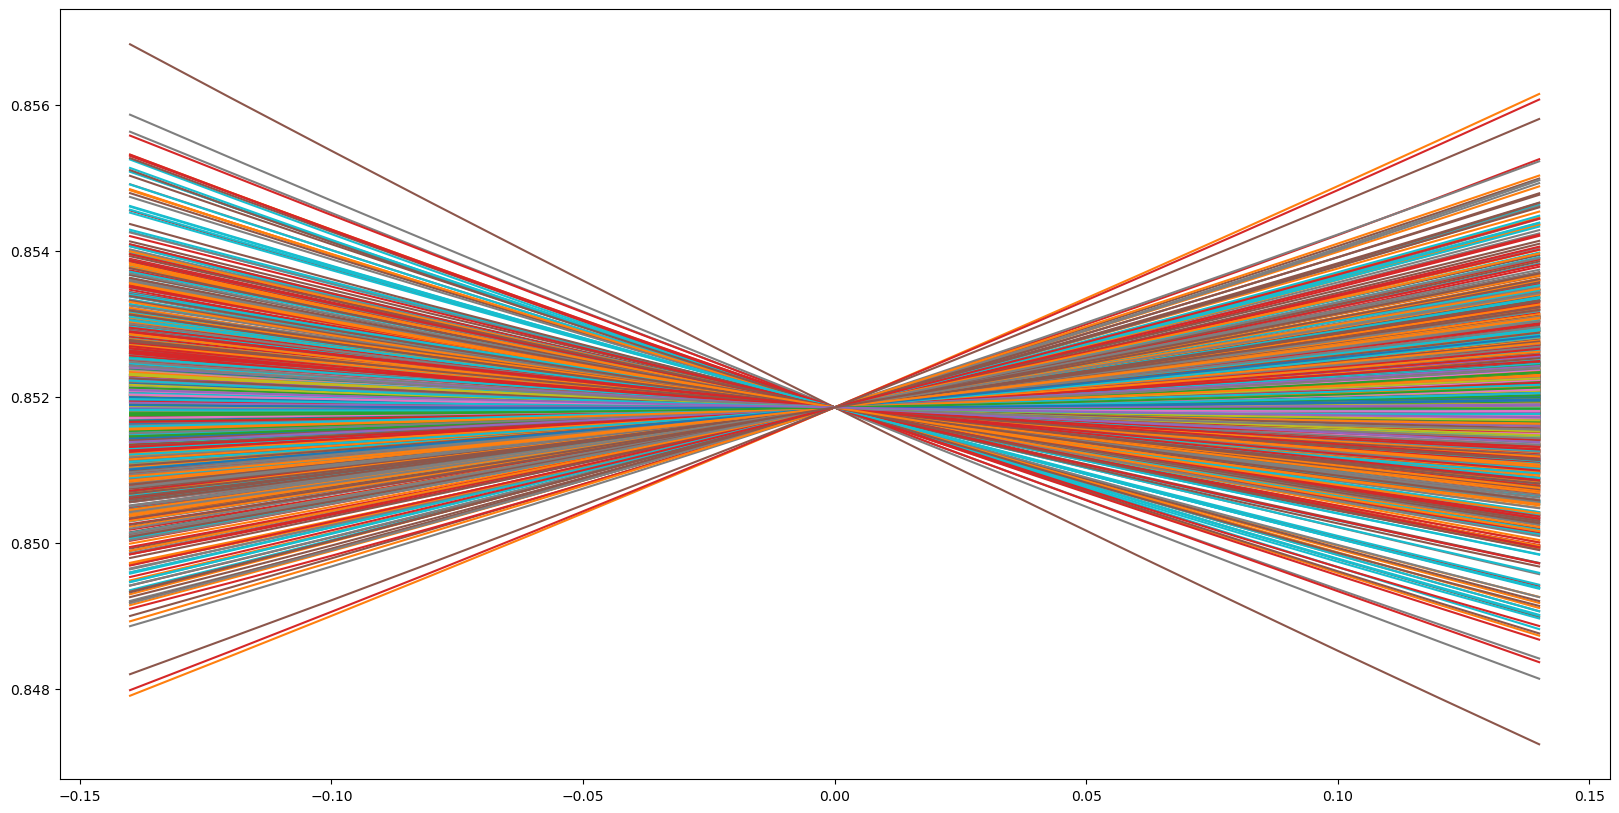

In [370]:
if tEval.dim() == 3:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    for i in range(tEval.shape[1]):
        for j in range(tEval.shape[2]):
            ax.plot(tRange.detach().cpu().numpy(), tEval[:, i, j].detach().cpu().numpy())
                
if tEval.dim() == 2:
    fig, ax = plt.subplots(2, 1, figsize=(5, 5))
    for i in range(tEval.shape[1]):
        ax[i].plot(tRange.detach().cpu().numpy(), tEval[:, i].detach().cpu().numpy())

In [7]:
sRunName = "test_moving_clip"
dLearningRate = 1e-1
dEps = 1e-3 # NOTE: It seems that the -LL is computed wrt to e, not base 10! Hence e^(-dEps) = L
dWeightDecay = 0
iBreakAtEpochs = 1e4
iBatchSize = min(32, iClaims)
optimizer = ConstantStepOptimizer(ae.parameters(), lr=dLearningRate)
# optimizer = optim.Adam(ae.parameters(), lr=dLearningRate, weight_decay=dWeightDecay)

iEpoch = 0
lLoss = []
lTime = []
while True:

    iEpoch += 1
    tic = time.time()
    
    optimizer.zero_grad()
    
    # NOTE: Necessary to keep making use of batching of the LLM, otherwise runs sequential ...
    loss = ForwardPass(tOHETarget, tInputEmbeddings, tTarget, model, ae, iBatchSize)
    
    #get_dot = register_hooks(loss)
    loss.backward(retain_graph=True)
    lLoss.append(loss.item())
    
    optimizer.step()

    toc = time.time()
    dTime = toc - tic
    lTime.append(dTime)
    
    if (iEpoch % 10 == 0) or (iEpoch == 1):
        print(f"Epoch {iEpoch}, Loss: {loss.item()}, Avg. time per Epoch {np.mean(lTime):.2f} sec")
    
    if iEpoch >= iBreakAtEpochs:
        break
    
    if loss.item() < dEps:
        break

Epoch 1, Loss: 6.650392055511475, Avg. time per Epoch 3.47 sec


KeyboardInterrupt: 